In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the dataset
df = pd.read_csv('creditcard.csv')

# Create traditional features
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize the traditional features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create mechanistic features
def add_mechanistic_features(df):
    # Geographical velocity (placeholder, as the actual dataset does not contain geolocation data)
    df['geographical_velocity'] = np.random.random(size=len(df))  # Example placeholder feature
    
    # Behavioral patterns (e.g., standard deviation of amounts over a rolling window)
    df['amount_std'] = df['Amount'].rolling(window=5).std().fillna(0)

    # Time-based patterns (e.g., time of transaction encoded as cyclic feature)
    df['hour'] = df['Time'].apply(lambda x: (x % 86400) // 3600)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Simulate some device and IP address consistency (placeholders)
    df['device_change'] = np.random.randint(0, 2, size=len(df))
    df['ip_change'] = np.random.randint(0, 2, size=len(df))

    return df

# Apply the mechanistic features to the dataset
df = add_mechanistic_features(df)

# Separate features and target variable again after adding new features
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize the updated feature set
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Feature engineering completed.")


Feature engineering completed.


In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Train traditional model using only the original features
X_train_traditional = X_train[:, :30]  # Assuming the original features are the first 30 columns
X_test_traditional = X_test[:, :30]

model_traditional = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_traditional.fit(X_train_traditional, y_train)

# Predictions and evaluation for the traditional model
y_pred_traditional = model_traditional.predict(X_test_traditional)
y_prob_traditional = model_traditional.predict_proba(X_test_traditional)[:, 1]

precision_traditional = precision_score(y_test, y_pred_traditional)
recall_traditional = recall_score(y_test, y_pred_traditional)
f1_traditional = f1_score(y_test, y_pred_traditional)
auc_traditional = roc_auc_score(y_test, y_prob_traditional)

print(f"Traditional Model - Precision: {precision_traditional}, Recall: {recall_traditional}, F1-Score: {f1_traditional}, AUC-ROC: {auc_traditional}")


Traditional Model - Precision: 0.9620253164556962, Recall: 0.7755102040816326, F1-Score: 0.8587570621468926, AUC-ROC: 0.9811164195560047


In [3]:
# Train hybrid model using all features (traditional + mechanistic)
model_hybrid = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_hybrid.fit(X_train, y_train)

# Predictions and evaluation for the hybrid model
y_pred_hybrid = model_hybrid.predict(X_test)
y_prob_hybrid = model_hybrid.predict_proba(X_test)[:, 1]

precision_hybrid = precision_score(y_test, y_pred_hybrid)
recall_hybrid = recall_score(y_test, y_pred_hybrid)
f1_hybrid = f1_score(y_test, y_pred_hybrid)
auc_hybrid = roc_auc_score(y_test, y_prob_hybrid)

print(f"Hybrid Model - Precision: {precision_hybrid}, Recall: {recall_hybrid}, F1-Score: {f1_hybrid}, AUC-ROC: {auc_hybrid}")


Hybrid Model - Precision: 0.9746835443037974, Recall: 0.7857142857142857, F1-Score: 0.8700564971751412, AUC-ROC: 0.9817836039874588


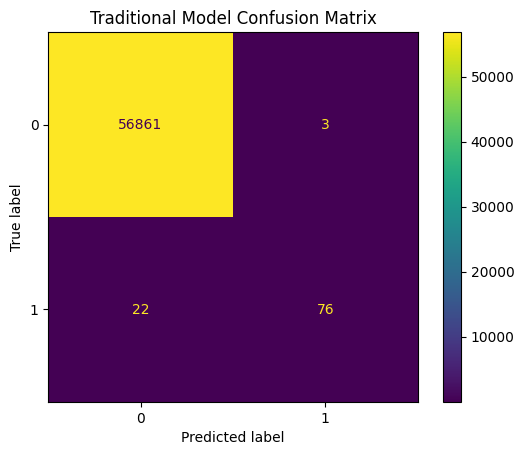

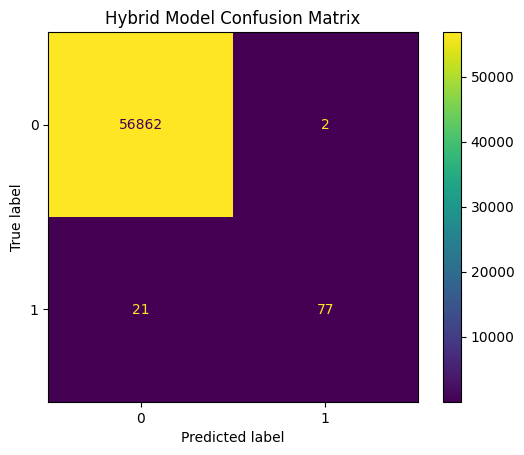

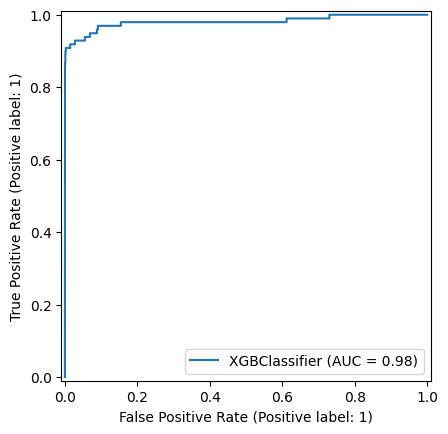

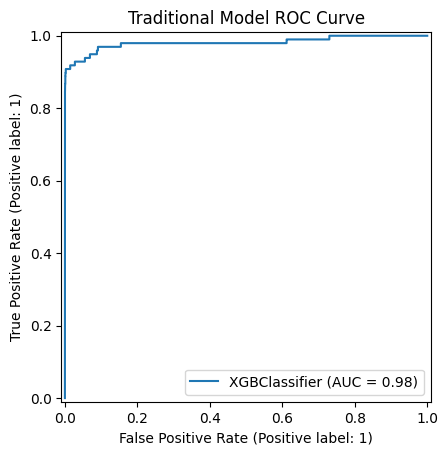

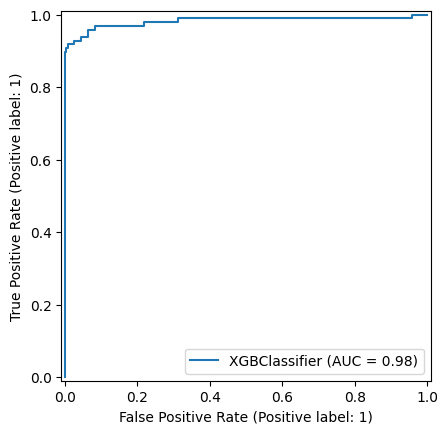

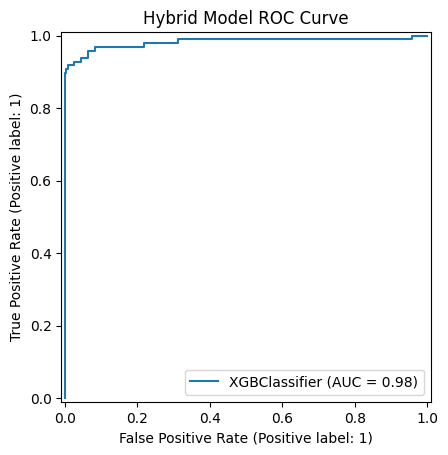

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

# Plot confusion matrix for traditional model
plot_confusion_matrix(y_test, y_pred_traditional, "Traditional Model Confusion Matrix")

# Plot confusion matrix for hybrid model
plot_confusion_matrix(y_test, y_pred_hybrid, "Hybrid Model Confusion Matrix")

# Function to plot ROC curve
def plot_roc(model, X_test, y_test, title):
    roc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
    roc_disp.plot()
    plt.title(title)
    plt.show()

# Plot ROC curve for traditional model
plot_roc(model_traditional, X_test_traditional, y_test, "Traditional Model ROC Curve")

# Plot ROC curve for hybrid model
plot_roc(model_hybrid, X_test, y_test, "Hybrid Model ROC Curve")


In [8]:
import shap

# Initialize SHAP explainer for traditional model
explainer_traditional = shap.Explainer(model_traditional, X_test_traditional)
shap_values_traditional = explainer_traditional(X_test_traditional)

# Plot SHAP summary for traditional model
shap.summary_plot(shap_values_traditional, X_test_traditional, feature_names=df.columns[:30])

# Initialize SHAP explainer for hybrid model
explainer_hybrid = shap.Explainer(model_hybrid, X_test)
shap_values_hybrid = explainer_hybrid(X_test)

# Plot SHAP summary for hybrid model
shap.summary_plot(shap_values_hybrid, X_test, feature_names=df.columns)


c:\Users\krishkum\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 49%|==========          | 27764/56962 [01:41<01:46]       

In [7]:
# Load new data
new_data = pd.read_csv('small_creditcard.csv')

# Preprocess new data
new_data = add_mechanistic_features(new_data)
X_new = new_data.drop('Class', axis=1)  # Assuming 'Class' is present in the new data for evaluation
X_new_scaled = scaler.transform(X_new)

# Predict using traditional model
X_new_traditional = X_new_scaled[:, :30]  # Assuming the original features are the first 30 columns
y_new_pred_traditional = model_traditional.predict(X_new_traditional)
y_new_prob_traditional = model_traditional.predict_proba(X_new_traditional)[:, 1]

# Predict using hybrid model
y_new_pred_hybrid = model_hybrid.predict(X_new_scaled)
y_new_prob_hybrid = model_hybrid.predict_proba(X_new_scaled)[:, 1]

# Evaluate new data predictions
precision_new_traditional = precision_score(new_data['Class'], y_new_pred_traditional)
recall_new_traditional = recall_score(new_data['Class'], y_new_pred_traditional)
f1_new_traditional = f1_score(new_data['Class'], y_new_pred_traditional)
auc_new_traditional = roc_auc_score(new_data['Class'], y_new_prob_traditional)

precision_new_hybrid = precision_score(new_data['Class'], y_new_pred_hybrid)
recall_new_hybrid = recall_score(new_data['Class'], y_new_pred_hybrid)
f1_new_hybrid = f1_score(new_data['Class'], y_new_pred_hybrid)
auc_new_hybrid = roc_auc_score(new_data['Class'], y_new_prob_hybrid)

print(f"Traditional Model on New Data - Precision: {precision_new_traditional}, Recall: {recall_new_traditional}, F1-Score: {f1_new_traditional}, AUC-ROC: {auc_new_traditional}")
print(f"Hybrid Model on New Data - Precision: {precision_new_hybrid}, Recall: {recall_new_hybrid}, F1-Score: {f1_new_hybrid}, AUC-ROC: {auc_new_hybrid}")


Traditional Model on New Data - Precision: 1.0, Recall: 1.0, F1-Score: 1.0, AUC-ROC: 1.0
Hybrid Model on New Data - Precision: 1.0, Recall: 1.0, F1-Score: 1.0, AUC-ROC: 1.0
